In [1]:
import pandas as pd
import numpy as np
from math import degrees,atan,asin,sqrt,pow, atan2
from os import listdir
from os.path import isfile, join
import networkx as nx
import os
import shutil
from LoopFlow import calculate_flow as cf
from datetime import datetime

pip install scikit-fmm


In [2]:
def dircos2ddd(l, m, n):
    if(m > 0):
        dipdir = (360+degrees(atan(l/m))) % 360
    elif(m < 0):
        dipdir = (540+degrees(atan(l/m))) % 360
    else:
        dipdir = 90
    dip = 90-degrees(asin(n))
    if(dip>90):
        dip=180-dip
        dipdir=dipdir+180
    dipdir=dipdir%360

    return(dip, dipdir)

def pts2dircos(p1x, p1y, p2x, p2y):
    dlsx = p1x-p2x
    dlsy = p1y-p2y
    if(p1x == p2x and p1y == p2y):
        return(0, 0)
    l = dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
    m = dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))
    return(l, m)


def ptsdist(p1x, p1y, p2x, p2y):
    dist = sqrt(pow(p1x-p2x, 2)+pow(p1y-p2y, 2))
    return(dist)

In [3]:
def process_surface(surf_path,tri_format,header):
    if(tri_format=='.obj'):
        surface=pd.read_csv(surf_path,sep=' ',names=['type','X','Y','Z'])
        vertices=surface[surface['type']=='v'].drop('type',axis=1)
        triangles=surface[surface['type']=='f'].drop('type',axis=1)
    elif(tri_format=='.ts' or tri_format=='.mx'):
        with open(surf_path) as f:
            datafile = f.readlines()
            for i,line in enumerate(datafile):
                if('TFACE' in line):
                    header=i+1
                    break
            #print('header',header)
        surface=pd.read_csv(surf_path,sep=' ',names=['type','a','b','c','d'],usecols=[0,1,2,3,4],skiprows=header, index_col=False)
        vertices=surface[surface['type']=='VRTX'].drop(['type'],axis=1)
        if(len(vertices)==0):
            vertices=surface[surface['type']=='PVRTX'].drop(['type'],axis=1)
        
        vertices['aint']=vertices.a.astype('int')
        vertices=vertices.set_index('aint')
        vertices=vertices.drop(['a'],axis=1)
        vertices.columns=['X','Y','Z']
        
        atoms=surface[surface['type']=='ATOM'].drop(['type'],axis=1)
        atoms_list={}
        for ind,a in atoms.iterrows():
            #print(vertices.loc[a.b],a.a)
            atoms_list[int(a.a)]={'X':vertices.loc[a.b].X,'Y':vertices.loc[a.b].Y,'Z':vertices.loc[a.b].Z,}
        atoms_list_df=pd.DataFrame.from_dict(atoms_list,orient='index')
        vertices=pd.concat([vertices,atoms_list_df])
    
        triangles=surface[surface['type']=='TRGL'].drop(['type','d'],axis=1)
        
    triangles.columns=['v1','v2','v3']
    triangles['V1']=triangles.v1.astype('int')
    triangles['V2']=triangles.v2.astype('int')
    triangles['V3']=triangles.v3.astype('int')
    triangles=triangles.drop(['v1','v2','v3'],axis=1)
    if(tri_format=='.obj'):
        triangles=triangles-1
        
    if('xxx.ts' in surf_path):
        display('s',surface,'t',triangles,'v',vertices)
        
    tri=[triangles.index,vertices.loc[triangles.V1]['X'],vertices.loc[triangles.V1]['Y'],vertices.loc[triangles.V1]['Z'],
     vertices.loc[triangles.V2]['X'],vertices.loc[triangles.V2]['Y'],vertices.loc[triangles.V2]['Z'],
     vertices.loc[triangles.V3]['X'],vertices.loc[triangles.V3]['Y'],vertices.loc[triangles.V3]['Z']]
    
    tri_df=pd.DataFrame(tri)
    tri_df=tri_df.transpose()
    tri_df.columns=['tnum','x1','y1','z1','x2','y2','z2','x3','y3','z3']
    #display(tri_df)
    
    # calc mean orientation of triangles
    p1=np.array([tri_df.x1,tri_df.y1,tri_df.z1])
    p2=np.array([tri_df.x2,tri_df.y2,tri_df.z2])
    p3=np.array([tri_df.x3,tri_df.y3,tri_df.z3])
    p1=p1.T.copy()
    p2=p2.T.copy()
    p3=p3.T.copy()
    v1 = p3 - p1
    v2 = p2 - p1
    cp = np.cross(v1, v2)
    cp=cp.T.copy()
    a, b, c = cp
    d = np.dot(cp, p3) # ax +by +cz=d is eqn of plane

    norm=np.sqrt(a*a+b*b+c*c)
    norm2d=np.sqrt(a*a+b*b)
    
    norm=norm+1e-7 # fix hz planes
    norm2d=norm2d+1e-7 #fix hz planes
    
    l=a/norm
    m=b/norm
    
    l2=a/norm2d
    m2=b/norm2d
    lm2_df=pd.DataFrame(l2,columns=['lsx'])
    lm2_df['lsy']=m2
    lm2_df=lm2_df[~lm2_df.lsx.isna()]

    n=c/norm
    
    l=l[~np.isnan(l).any(), :]
    m=m[~np.isnan(l).any(), :]
    n=n[~np.isnan(l).any(), :]

    lm=l.mean()
    mm=m.mean()
    nm=n.mean()
    
    lm2=lm/sqrt(lm**2+mm**2+nm**2)
    mm2=mm/sqrt(lm**2+mm**2+nm**2)
    nm2=nm/sqrt(lm**2+mm**2+nm**2)
    dip,dipdir=dircos2ddd(lm2,mm2,nm2)
    if(np.isnan(dip)):
        dip=0
    return(dip,dipdir,vertices,lm2_df,tri_df)

In [4]:
contacts=pd.DataFrame(columns=['index','X','Y','Z','formation','source'])
orientations=pd.DataFrame(columns=['X','Y','Z','azimuth','dip','polarity','formation','source'])
raw_contacts=pd.DataFrame(columns=['X','Y','Z','angle','lsx','lsy','formation','group'])
fault_contacts=pd.DataFrame(columns=['X','Y','Z','formation'])
fault_orientations=pd.DataFrame(columns=['X','Y','Z','DipDirection','dip','DipPolarity','formation'])
fault_dimensions=pd.DataFrame(columns=['Fault','HorizontalRadius','VerticalRadius','InfluenceDistance','incLength','colour'])
fault_displacements=pd.DataFrame(columns=['X','Y','fname','apparent_displacement','vertical_displacement','downthrow_dir'])
 
all_sorts=pd.DataFrame(columns=['index','group number','index in group','number in group','code','group','strat_type','supergroup','uctype','colour','meanz'])

tri_format='.ts' # 'obj' vs '.ts' or '.mx'


root_dir='../'


if(tri_format=='.obj'):
    fault_code='Fault_'
    obj_path_dir='./leapfrog_layers/'
    dem_word='dtm'
else:
    fault_code=['fault_','Fault_']
    obj_path_dir=root_dir+'tsurfs/'
    dem_word='DEM'
    
    

onlyfiles = [f for f in listdir(obj_path_dir) if isfile(join(obj_path_dir, f))]
strati=0
faulti=0
total_strat=0
header=0

xmin=ymin=zmin=1e9
xmax=ymax=zmax=-1e9

for file in onlyfiles:
    if (tri_format in file and not any(word in file for word in fault_code) and not dem_word in file):
        total_strat=total_strat+1

for file in onlyfiles:

    froot=file.replace(tri_format,'')
    if (tri_format in file and any(word in file for word in fault_code)):
        print('process fault',file)
        dip,dipdir,vertices,lm2_df,tri=process_surface(obj_path_dir+file,tri_format,header)
        vertices['formation']=froot
        vmean=[vertices.X.mean(),vertices.Y.mean(),vertices.Z.mean()]
        a_vertex=vertices.sample(1)
        fault_contacts=pd.concat([fault_contacts,vertices])
        fault_orientations.loc[faulti]={'X':a_vertex.iloc[0].X,'Y':a_vertex.iloc[0].Y,'Z':a_vertex.iloc[0].Z,'DipDirection':dipdir,'dip':dip,'DipPolarity':1,'formation':froot}
        
        fault_hr=0.5*sqrt((vertices.X.max()-vertices.X.min())**2+(vertices.Y.max()-vertices.Y.min())**2)#+(vertices.Z.max()-vertices.Z.min())**2)
        fault_vr=fault_hr
        fault_id=fault_hr/2
        fault_dimensions.loc[faulti]={'Fault':froot,'HorizontalRadius':fault_hr,'VerticalRadius':fault_vr,'InfluenceDistance':fault_id,'incLength':fault_hr,'colour':'#b07670'}
        fault_displacements.loc[faulti]={'X':vmean[0],'Y':vmean[1],'fname':froot,'apparent_displacement':fault_hr/10000,'vertical_displacement':fault_hr/10000,'downthrow_dir':dipdir}

        faulti=faulti+1
        
        xmin=min(vertices.X.min(),xmin)
        xmax=max(vertices.X.max(),xmax)
        ymin=min(vertices.Y.min(),ymin)
        ymax=max(vertices.Y.max(),ymax)
        zmin=min(vertices.Z.min(),zmin)
        zmax=max(vertices.Z.max(),zmax)        
        
    elif(tri_format in file and not dem_word in file):
        print('process strat',file)
        dip,dipdir,vertices,lm2_df,tri=process_surface(obj_path_dir+file,tri_format,header)
        print(dip,dipdir)
        vertices['index']=0
        vertices['source']='triangulation'
        vertices['formation']=froot
        contacts=pd.concat([contacts,vertices])
        vmean=[vertices.X.mean(),vertices.Y.mean(),vertices.Z.mean()]
        orientations.loc[strati]={'X':vmean[0],'Y':vmean[1],'Z':vmean[2],'azimuth':dipdir,'dip':dip,'polarity':1,'formation':froot,'source':'triangulation'}
        all_sorts.loc[strati]={'index':strati,'group number':0,'index in group':strati,'number in group':total_strat,'code':froot,'group':'all_same','strat_type':'sediment','supergroup':'supergroup_0','uctype':'erode','colour':'#E0CABF','meanz':vertices.Z.mean()}
        lm2_df['angle']=np.degrees(np.arctan2(lm2_df.lsx,lm2_df.lsy))
        lm2_df['X']=(tri.x1+tri.x2+tri.x3)/3
        lm2_df['Y']=(tri.y1+tri.y2+tri.y3)/3
        lm2_df['Z']=(tri.z1+tri.z2+tri.z3)/3
        lm2_df['formation']=froot
        lm2_df['group']='all_same'
        lm2_df=lm2_df[['X','Y','Z','angle','lsx','lsy','formation','group']]
        raw_contacts=pd.concat([raw_contacts,lm2_df])
        strati=strati+1
        
        xmin=min(vertices.X.min(),xmin)
        xmax=max(vertices.X.max(),xmax)
        ymin=min(vertices.Y.min(),ymin)
        ymax=max(vertices.Y.max(),ymax)
        zmin=min(vertices.Z.min(),zmin)
        zmax=max(vertices.Z.max(),zmax)        
        
    elif(tri_format in file  and 'dtm' in file):
        print("don't process dtm",file)

        
    
    
contacts['index']=range(len(contacts))
zmax=zmax+500
print(xmin,xmax,ymin,ymax,zmin,zmax)


process strat 3_Pandurra_Surface_Final.ts
0.2159891765006421 358.2636400995427
process fault Fault_Surface_01_Final.ts
process fault Fault_Surface_02_Final.ts
process fault Fault_Surface_03_Final.ts
process strat 6_Donington_Surface_both.ts
1.5694917494370628 51.72259138256703
process fault Fault_Surface_04_Final.ts
process strat 4_Gawler_Range_Volcanics_Surface_Final.ts
1.4299838052434808 207.50008452393354
process strat 1_Neoprotozoic_Surface_Final.ts
0.24326786406808765 283.29437814584645
process fault Fault_Surface_05_Final.ts
process strat 5_Wallaroo_Group_Surface_Final.ts
0.22647126630863568 224.73332614152946
664928.328125 726000.09375 6542999.90625 6596000.015625 -10000.0 733.7555084228516


In [5]:
#process dykes as faults
dykes=pd.read_csv(obj_path_dir+'/dykes/DYKES.csv') 
dykes=dykes.drop(columns=['Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7'])
dykes['formation']='Fault_dyke_'+dykes.formation.astype('str')
dykes=dykes[['X','Y','Z','formation']]
for dyke in dykes.formation.unique():
    adyke=dykes[dykes.formation==dyke]
    bdyke=adyke.copy(deep=True)
    bdyke['Z']=bdyke['Z']-10000.0
    fault_contacts=pd.concat([fault_contacts,adyke,bdyke])
    
    dminx=adyke.X.min()
    dmaxx=adyke.X.max()
    dminy=adyke.Y.min()
    dmaxy=adyke.Y.max()
    length=ptsdist(dminx, dminy, dmaxx, dmaxy)
    l,m=pts2dircos(dminx, dminy, dmaxx, dmaxy)
    dipdir=(180-degrees(atan2(m,-l))) % 360
    
    vmean=[adyke.X.mean(),adyke.Y.mean(),adyke.Z.mean()-5000.0]
    
    fault_orientations.loc[faulti]={'X':vmean[0],'Y':vmean[1],'Z':vmean[2],'DipDirection':dipdir,'dip':90.0,'DipPolarity':1,'formation':dyke}

    fault_hr=0.5*sqrt((adyke.X.max()-adyke.X.min())**2+(adyke.Y.max()-adyke.Y.min())**2)#+(vertices.Z.max()-vertices.Z.min())**2)
    fault_vr=fault_hr
    fault_id=fault_hr/2
    fault_dimensions.loc[faulti]={'Fault':dyke,'HorizontalRadius':fault_hr,'VerticalRadius':fault_vr,'InfluenceDistance':fault_id,'incLength':fault_hr,'colour':'#b07670'}
    fault_displacements.loc[faulti]={'X':vmean[0],'Y':vmean[1],'fname':dyke,'apparent_displacement':fault_hr/10000,'vertical_displacement':fault_hr/10000,'downthrow_dir':dipdir}

    faulti=faulti+1
    

In [6]:
# calc formation thicknesses from mean Z values

all_sorts2=all_sorts.sort_values(by='meanz',ascending=False)
all_sorts2=all_sorts2.reset_index()
all_sorts2['index']=all_sorts2.index
all_sorts2=all_sorts2.drop('level_0',axis=1)
formation_thickness=pd.DataFrame(columns=['formation','thickness median','thickness std','method'])
for ind,a_s in all_sorts2[1:].iterrows():
    formation_thickness.loc[ind]={'formation':a_s.code,'thickness median':all_sorts2.loc[ind-1].meanz-a_s.meanz,'thickness std':(all_sorts2.loc[ind-1].meanz-a_s.meanz)/2,'method':'meanz'}
formation_thickness.loc[0]={'formation':all_sorts2.loc[0].code,'thickness median':10000,'thickness std':10000,'method':'meanz'}
#formation_thickness.loc[len(all_sorts2)-1]={'formation':all_sorts2.loc[len(all_sorts2)-1].code,'thickness median':10000,'thickness std':10000,'method':'meanz'}

all_sorts2.loc[0,'supergroup']='supergroup_1'
all_sorts2.loc[1,'supergroup']='supergroup_1'
all_sorts2.loc[0,'group']='upper'
all_sorts2.loc[1,'group']='upper'
all_sorts2

,index,group number,index in group,number in group,code,group,strat_type,supergroup,uctype,colour,meanz
0,0,0,3,5,1_Neoprotozoic_Surface_Final,upper,sediment,supergroup_1,erode,#E0CABF,-198.262433
1,1,0,0,5,3_Pandurra_Surface_Final,upper,sediment,supergroup_1,erode,#E0CABF,-750.932778
2,2,0,2,5,4_Gawler_Range_Volcanics_Surface_Final,all_same,sediment,supergroup_0,erode,#E0CABF,-973.733627
3,3,0,4,5,5_Wallaroo_Group_Surface_Final,all_same,sediment,supergroup_0,erode,#E0CABF,-1193.157558
4,4,0,1,5,6_Donington_Surface_both,all_same,sediment,supergroup_0,erode,#E0CABF,-3657.976126


In [7]:
# fault-fault and group-fault relationships
columns=[]
for ind,f in fault_dimensions.iterrows():
    columns.append(f.Fault)

ff_arr=np.zeros((len(fault_dimensions),len(fault_dimensions)),dtype=int)
fault_fault=pd.DataFrame(ff_arr,index=columns,columns=columns)

gf_arr=np.ones((2,len(fault_dimensions)),dtype=int)
group_fault=pd.DataFrame(gf_arr,index=['upper','all_same'],columns=columns)

sgf_arr=np.ones((2,len(fault_dimensions)),dtype=int)
supergroup_fault=pd.DataFrame(sgf_arr,index=['supergroup_1','supergroup_0'],columns=columns)
supergroup_fault.index.names = ['supergroup']

fault_fault_graph= nx.DiGraph()
for ind,f in fault_dimensions.iterrows():
    fault_fault_graph.add_node(f.Fault)

f_f_txt=pd.DataFrame(columns=['0'])

In [8]:
# create super_groups
super_groups=pd.DataFrame(columns=['0'],index=[0,1])
super_groups.loc[0]={'0':'upper'}
super_groups.loc[1]={'0':'all_same'}

In [9]:
# create bbox

bbox=pd.DataFrame(columns=['minx','miny','maxx','maxy','lower','upper'])
bbox.loc[0]={'minx':xmin,'miny':ymin,'maxx':xmax,'maxy':ymax,'lower':zmin,'upper':zmax}


In [10]:
#define and create paths
out_dir=root_dir+'/exported/'

if(not os.path.isdir(out_dir)):
    os.mkdir(out_dir)
if(not os.path.isdir(out_dir+'/output')):
    os.mkdir(out_dir+'/output')
if(not os.path.isdir(out_dir+'/dtm')):
    os.mkdir(out_dir+'/dtm')
if(not os.path.isdir(out_dir+'/tmp')):
    os.mkdir(out_dir+'/tmp')
if(not os.path.isdir(out_dir+'/graph')):
    os.mkdir(out_dir+'/graph')
if(not os.path.isdir(out_dir+'/vtk')):
    os.mkdir(out_dir+'/vtk')



In [11]:
#define decimation of large datasets

fault_contact_frac=0.5
raw_contact_frac=0.2
strat_contact_frac=0.25


In [12]:
#add fake basement outside box
basement=False
if(basement):


    b_o={'X':xmin+(xmax-xmin)/2, 'Y':ymin+(ymax-ymin)/2, 'Z':zmin-100, 'azimuth':123, 'dip':0.1, 'polarity':1, 'formation':'Basement', 'source':'triangulation'}
    b_o_df=pd.DataFrame(b_o,index=[len(orientations)])


    b_c1={'index':len(contacts), 'X':xmin, 'Y':ymin, 'Z':zmin, 'formation':'Basement', 'source':'triangulation'}
    b_c2={'index':len(contacts)+1, 'X':xmin, 'Y':ymax, 'Z':zmin, 'formation':'Basement', 'source':'triangulation'}
    b_c3={'index':len(contacts)+2, 'X':xmax, 'Y':ymax, 'Z':zmin, 'formation':'Basement', 'source':'triangulation'}
    b_c4={'index':len(contacts)+3, 'X':xmax, 'Y':ymin, 'Z':zmin, 'formation':'Basement', 'source':'triangulation'}
    b_c_df1=pd.DataFrame(b_c1,index=[len(contacts)])
    b_c_df2=pd.DataFrame(b_c2,index=[len(contacts)+1])
    b_c_df3=pd.DataFrame(b_c3,index=[len(contacts)+2])
    b_c_df4=pd.DataFrame(b_c4,index=[len(contacts)+3])
    contacts3=pd.concat([b_c_df1,b_c_df2,b_c_df3,b_c_df4])

    b_as={'index':len(all_sorts), 'group number':'0', 'index in group':len(all_sorts), 'number in group':len(all_sorts), 'code':'Basement',
           'group':'all_same', 'strat_type':'sediment', 'supergroup':'supergroup_0', 'uctype':'erode', 'colour':'#777777', 'meanz':zmin-100}
    b_as_df=pd.DataFrame(b_as,index=[len(all_sorts2)])
    all_sorts2=pd.concat([all_sorts2,b_as_df])

    b_fm_th={'formation':'Basement','thickness median':2000,'thickness std':1000,'method':'meanz'}
    b_fm_th_df=pd.DataFrame(b_fm_th,index=[len(formation_thickness)])
    formation_thickness=pd.concat([formation_thickness,b_fm_th_df])


In [13]:
#save out all outputs ready for LoopStructural (with decimation)

raw_contacts.sample(frac=raw_contact_frac).to_csv(out_dir + '/tmp/raw_contacts.csv',index=False)
all_sorts2.to_csv(out_dir + '/tmp/all_sorts_clean.csv',index=False)

orientations.to_csv(out_dir + '/output/orientations_clean.csv',index=False)
contacts.sample(frac=strat_contact_frac).to_csv(out_dir + '/output/contacts_clean.csv',index=False)

#add fake basement after decimation
if(basement):
    orientations2=pd.read_csv(out_dir + '/output/orientations_clean.csv')

    orientations2=pd.concat([orientations2,b_o_df])

    contacts2=pd.read_csv(out_dir + '/output/contacts_clean.csv')
    contacts2=pd.concat([contacts2,contacts3])

    orientations2.to_csv(out_dir + '/output/orientations_clean.csv',index=False)
    contacts2.to_csv(out_dir + '/output/contacts_clean.csv')
    


fault_displacements.to_csv(out_dir + '/output/fault_displacements3.csv',index=False)
fault_orientations.to_csv(out_dir + '/output/fault_orientations.csv',index=False)
fault_contacts.sample(frac=fault_contact_frac).to_csv(out_dir + '/output/faults.csv',index=False)
fault_fault.to_csv(out_dir + '/output/fault-fault-relationships.csv')
group_fault.to_csv(out_dir + '/output/group-fault-relationships.csv')
supergroup_fault.to_csv(out_dir + '/output/supergroup-fault-relationships.csv')
fault_dimensions.to_csv(out_dir + '/output/fault_dimensions.csv',index=False)
nx.write_gml(fault_fault_graph,out_dir + '/tmp/fault_network.gml')
super_groups.to_csv(out_dir + '/tmp/super_groups.csv',header=False,index=False)
bbox.to_csv(out_dir+'/tmp/bbox.csv',index=False)
f_f_txt.to_csv(out_dir+'/graph/fault-fault-intersection.txt',header=False,index=False) 
formation_thickness.to_csv(out_dir + '/output/formation_summary_thicknesses.csv',index=False)

In [14]:
#get dtm
import rasterio
from shapely.geometry import Point
import geopandas as gpd
from owslib.wcs import WebCoverageService
from rasterio.warp import calculate_default_transform, reproject, Resampling

try:
    shutil.copyfile(obj_path_dir+'dtm_rp.tif', out_dir + '/dtm/'+'dtm_rp.tif')
except:
    def get_dtm(path_out, minlong, maxlong, minlat, maxlat,
                url="http://services.ga.gov.au/gis/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?"
                ):

        bbox = (minlong, minlat, maxlong, maxlat)

        wcs = WebCoverageService(url, version='1.0.0')

        cvg = wcs.getCoverage(identifier='1',  bbox=bbox,
                              format='GeoTIFF', crs=4326, width=200, height=200)

        f = open(path_out, 'wb')
        bytes_written = f.write(cvg.read())
        f.close()
        print("dtm geotif saved as", path_out) 
        
    def reproject_dtm(path_in, path_out, src_crs, dst_crs):
        with rasterio.open(path_in) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(path_out, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                dst.close()
        print("reprojected dtm geotif saved as", path_out)
        
    corner_pts = {'col1': ['bl', 'tr'], 'geometry': [Point(bbox.minx,bbox.miny), Point(bbox.maxx,bbox.maxy)]}    
    corner_pts_gpd=gpd.GeoDataFrame(corner_pts ,crs='epsg:28353' )  
    corner_pts_gpd=corner_pts_gpd.to_crs('epsg:4326')
    #display(corner_pts_gpd)
    
    get_dtm(out_dir+ '/dtm/'+'dtm.tif', corner_pts_gpd.loc[0].geometry.x-.1, corner_pts_gpd.loc[1].geometry.x+.1, corner_pts_gpd.loc[0].geometry.y-.1, corner_pts_gpd.loc[1].geometry.y+.1,
                url="http://services.ga.gov.au/gis/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?"
                )
    reproject_dtm(out_dir+ '/dtm/'+'dtm.tif', out_dir + '/dtm/'+'dtm_rp.tif', 'epsg:4326', 'epsg:28353')

dtm geotif saved as ..//exported//dtm/dtm.tif
reprojected dtm geotif saved as ..//exported//dtm/dtm_rp.tif


In [15]:
# Define project pathing from m2l
proj_path = out_dir
graph_path = out_dir+'/graph/'
tmp_path = out_dir+'/tmp/'
data_path = out_dir+'/output/'
dtm_path = out_dir+'/dtm/'
output_path = out_dir+'/output/'
vtk_path = out_dir+'/vtk/'


extra_depth=0

# Define project bounds
minx,miny,maxx,maxy = [bbox.iloc[0].minx,bbox.iloc[0].miny,bbox.iloc[0].maxx,bbox.iloc[0].maxy]
model_base =bbox.iloc[0].lower-extra_depth #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
model_top = bbox.iloc[0].upper



In [16]:
##############################
# Harmonise DataFrames to match code below
# ***********************

contacts_points=contacts.drop(columns=['index','source']).sample(frac=strat_contact_frac)
contacts_points=contacts_points.rename(columns={"formation": "name"})
contacts_points

stratigraphic_orientations=orientations.copy()
stratigraphic_orientations=stratigraphic_orientations.rename(columns={"formation": "name"})
stratigraphic_orientations

stratigraphic_thickness=formation_thickness.drop(columns=['thickness std','method'])
stratigraphic_thickness=stratigraphic_thickness.rename(columns={"formation": "name","thickness median": "thickness"})
stratigraphic_thickness

stratigraphic_order=all_sorts2.drop(columns=['index','number in group','strat_type','uctype','colour','meanz'])
stratigraphic_order=stratigraphic_order.rename(columns={"code": "unit name","index in group": "order"})
stratigraphic_order

fault_orientations=fault_orientations.rename(columns={"formation": "feature_name","DipDirection": "dipdir"})
fault_orientations

fault_edges=[]
fault_edges

fault_properties=fault_displacements.drop(columns=['X','Y','apparent_displacement','downthrow_dir'])
fault_properties=fault_properties.rename(columns={"fname": "Fault","vertical_displacement": "displacement"})
fault_properties=fault_properties.set_index('Fault')
fault_properties

fault_locations=fault_contacts.rename(columns={"formation": "feature_name"})
fault_locations['val']=0
fault_locations['coord']=0
fault_locations


,X,Y,Z,feature_name,val,coord
1,692226.000000,6.581022e+06,-1938.648071,Fault_Surface_01_Final,0,0
2,692719.992188,6.581279e+06,-1301.050049,Fault_Surface_01_Final,0,0
3,692803.671875,6.581332e+06,-2447.307617,Fault_Surface_01_Final,0,0
4,693485.250000,6.581685e+06,-1613.804688,Fault_Surface_01_Final,0,0
5,692012.382812,6.580908e+06,-2735.413330,Fault_Surface_01_Final,0,0
...,...,...,...,...,...,...
883,667226.226562,6.547369e+06,-10311.639923,Fault_dyke_14,0,0
884,667103.429688,6.547684e+06,-10310.194000,Fault_dyke_14,0,0
885,667017.496094,6.547904e+06,-10309.182129,Fault_dyke_14,0,0
886,667009.308594,6.547925e+06,-10309.034393,Fault_dyke_14,0,0


In [17]:
stratigraphic_order

,group number,order,unit name,group,supergroup
0,0,3,1_Neoprotozoic_Surface_Final,upper,supergroup_1
1,0,0,3_Pandurra_Surface_Final,upper,supergroup_1
2,0,2,4_Gawler_Range_Volcanics_Surface_Final,all_same,supergroup_0
3,0,4,5_Wallaroo_Group_Surface_Final,all_same,supergroup_0
4,0,1,6_Donington_Surface_both,all_same,supergroup_0


In [18]:
basements = {'group number': [0,0], 'order': [5,1.5],'unit name':['basement','ubasement'],'group':['all_same','all_same'],'supergroup':['supergroup_0','supergroup_1']}
basements_df = pd.DataFrame(data=basements)
stratigraphic_order['order']=stratigraphic_order.index
stratigraphic_order=pd.concat([stratigraphic_order,basements_df])
stratigraphic_order=stratigraphic_order.sort_values(by='order')
stratigraphic_order=stratigraphic_order.reset_index()
stratigraphic_order['order']=stratigraphic_order.index

stratigraphic_order

,index,group number,order,unit name,group,supergroup
0,0,0,0,1_Neoprotozoic_Surface_Final,upper,supergroup_1
1,1,0,1,3_Pandurra_Surface_Final,upper,supergroup_1
2,1,0,2,ubasement,all_same,supergroup_1
3,2,0,3,4_Gawler_Range_Volcanics_Surface_Final,all_same,supergroup_0
4,3,0,4,5_Wallaroo_Group_Surface_Final,all_same,supergroup_0
5,4,0,5,6_Donington_Surface_both,all_same,supergroup_0
6,0,0,6,basement,all_same,supergroup_0


In [19]:
"""
4.a Building a model using the ProcessInputData
===============================================
There is a disconnect between the input data required by 3D modelling software and a geological map. 
In LoopStructural the geological model is a collection of implicit functions that can be mapped to the 
distribution of stratigraphic units and the location of fault surfaces. 
Each implicit function is approximated from the observations of the stratigraphy, 
this requires grouping conformable geological units together as a single implicit function, 
mapping the different stratigraphic horizons to a value of the implicit function and determining the 
relationship with geological structures such as faults. In this tutorial the **ProcessInputData** class 
will be used to convert geologically meaningful datasets to input for LoopStructural. The **ProcessInputData** 
class uses:* stratigraphic contacts* stratigraphic orientations* stratigraphic thickness* stratigraphic order 
To build a model of stratigraphic horizons and:* fault locations* fault orientations * fault properties* fault edges 
To use incorporate faults into the geological model. """

##############################
# Imports
# ~~~~~~~


from LoopStructural.modelling import ProcessInputData, Map2LoopProcessor
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.datasets import load_geological_map_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##############################
# Read stratigraphy from csv
# ~~~~~~~~~~~~~~~~~~~~~~~~~~

"""(
    xcontacts,
    xstratigraphic_orientations,
    xstratigraphic_thickness,
    xstratigraphic_order,
    xbbox,
    xfault_locations,
    xfault_orientations,
    xfault_properties,
    xfault_edges,
) = load_geological_map_data()"""

'(\n    xcontacts,\n    xstratigraphic_orientations,\n    xstratigraphic_thickness,\n    xstratigraphic_order,\n    xbbox,\n    xfault_locations,\n    xfault_orientations,\n    xfault_properties,\n    xfault_edges,\n) = load_geological_map_data()'

In [20]:
thicknesses = dict(
    zip(
        list(stratigraphic_thickness["name"]),
        list(stratigraphic_thickness["thickness"]),
    )
)
thicknesses['basement']=10000.0
thicknesses['ubasement']=100.0
thicknesses

{'3_Pandurra_Surface_Final': 552.6703455238364,
 '4_Gawler_Range_Volcanics_Surface_Final': 222.80084916273734,
 '5_Wallaroo_Group_Surface_Final': 219.4239306902948,
 '6_Donington_Surface_both': 2464.81856850017,
 '1_Neoprotozoic_Surface_Final': 10000.0,
 'basement': 10000.0,
 'ubasement': 100.0}

Text(0.5, 1.0, 'Contact data')

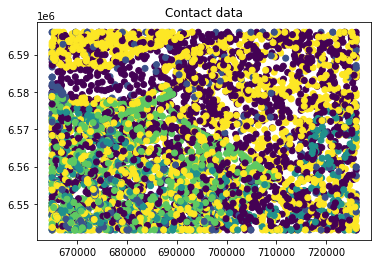

In [21]:
##############################
#  Stratigraphic Contacts
# ***********************

contacts

fig, ax = plt.subplots(1)
ax.scatter(
    contacts_points["X"], contacts_points["Y"], c=contacts_points["name"].astype("category").cat.codes
)
ax.set_title("Contact data")

Text(0.5, 1.0, 'Orientation data')

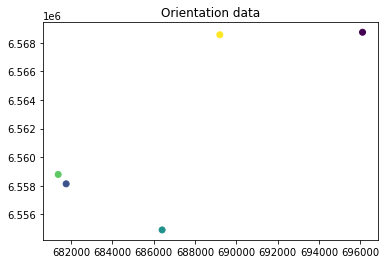

In [22]:
##############################
#  Stratigraphic Orientations
# ***********************

stratigraphic_orientations

fig, ax = plt.subplots(1)
ax.scatter(
    stratigraphic_orientations["X"], stratigraphic_orientations["Y"], c=stratigraphic_orientations["name"].astype("category").cat.codes
)
ax.set_title("Orientation data")

In [23]:
##############################
# Stratigraphic orientations
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
# Stratigraphic orientations needs to have X, Y, Z and either azimuth and dip, dipdirection and dip, strike and dip (RH thumb rule) or the vector components of the normal vector (nx, ny, nz)

stratigraphic_orientations

,X,Y,Z,azimuth,dip,polarity,name,source
0,681760.759926,6.558129e+06,-750.932778,358.263640,0.215989,1,3_Pandurra_Surface_Final,triangulation
1,689200.441070,6.568565e+06,-3657.976126,51.722591,1.569492,1,6_Donington_Surface_both,triangulation
2,686407.244759,6.554902e+06,-973.733627,207.500085,1.429984,1,4_Gawler_Range_Volcanics_Surface_Final,triangulation
3,696109.198742,6.568741e+06,-198.262433,283.294378,0.243268,1,1_Neoprotozoic_Surface_Final,triangulation
4,681374.941046,6.558785e+06,-1193.157558,224.733326,0.226471,1,5_Wallaroo_Group_Surface_Final,triangulation


In [24]:
##############################
# Stratigraphic thickness
# ~~~~~~~~~~~~~~~~~~~~~~~
# Stratigraphic thickness should be a dictionary containing the unit name (which should be in the contacts table) and the corresponding thickness of this unit.

thicknesses

{'3_Pandurra_Surface_Final': 552.6703455238364,
 '4_Gawler_Range_Volcanics_Surface_Final': 222.80084916273734,
 '5_Wallaroo_Group_Surface_Final': 219.4239306902948,
 '6_Donington_Surface_both': 2464.81856850017,
 '1_Neoprotozoic_Surface_Final': 10000.0,
 'basement': 10000.0,
 'ubasement': 100.0}

In [25]:
##############################
# Bounding box
# ~~~~~~~~~~~~
# * Origin - bottom left corner of the model # * Maximum - top right hand corner of the model


#origin = xbbox.loc["origin"].to_numpy()  # np.array(bbox[0].split(',')[1:],dtype=float)
#maximum = xbbox.loc["maximum"].to_numpy()  # np.array(bbox[1].split(',')[1:],dtype=float)


origin = np.array([bbox.iloc[0].minx,bbox.iloc[0].miny,bbox.iloc[0].lower])
maximum = np.array([bbox.iloc[0].maxx,bbox.iloc[0].maxy,bbox.iloc[0].upper])
bbox

,minx,miny,maxx,maxy,lower,upper
0,664928.328125,6.543000e+06,726000.09375,6.596000e+06,-10000.0,733.755508


In [26]:
##############################
# Stratigraphic column
# ~~~~~~~~~~~~~~~~~~~~
# The order of stratrigraphic units is defined a list of tuples containing the name of the group and the order of units within the group. For example there are 7 units in the following example that form two groups.

# example nested list
#stratigraphic_order
[                 
    ("youngest_group", ["unit1", "unit2", "unit3", "unit4"]),
    ("older_group", ["unit5", "unit6", "unit7"]),
]


#order = [("supergroup_0", list(stratigraphic_order["unit name"]))]
order = [("supergroup_0", list(stratigraphic_order["unit name"][:3])),("supergroup_1", list(stratigraphic_order["unit name"][3:])),]

In [27]:
from LoopStructural.visualisation.vtk_exporter import VtkExporter

##############################
# Building a stratigraphic model
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# A ProcessInputData onject can be built from these datasets using the argument names. A full list of possible arguments can be found in the documentation.

thicknesses['ubasement']=300.0

processor = ProcessInputData(
    contacts=contacts_points,
    contact_orientations=stratigraphic_orientations.rename(
        {"formation": "name"}, axis=1
    ),
    thicknesses=thicknesses,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum,
)

##############################
# The process input data can be used to directly build a geological model

model = GeologicalModel.from_processor(processor)
model.update()

##############################
# Or build directly from the dataframe and processor attributes.

"""model2 = GeologicalModel(processor.origin, processor.maximum)
model2.data = processor.data
model2.create_and_add_foliation("supergroup_0")
model2.create_and_add_foliation("supergroup_1")
model2.update()
"""

  0%|          | 0/2 [00:00<?, ?it/s]

'model2 = GeologicalModel(processor.origin, processor.maximum)\nmodel2.data = processor.data\nmodel2.create_and_add_foliation("supergroup_0")\nmodel2.create_and_add_foliation("supergroup_1")\nmodel2.update()\n'

In [28]:
##############################
# Adding faults
# ~~~~~~~~~~~~~


processor = ProcessInputData(
    contacts=contacts_points,
    contact_orientations=stratigraphic_orientations.rename(
        {"formation": "name"}, axis=1
    ),
    thicknesses=thicknesses,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum,
    #fault_edges=fault_edges,
    fault_orientations=fault_orientations,
    fault_locations=fault_locations,
    fault_properties=fault_properties,
    fault_edges=[('Fault_Surface_04_Final','Fault_Surface_01_Final',
                 'Fault_Surface_04_Final','Fault_Surface_02_Final',
                 'Fault_Surface_03_Final','Fault_Surface_01_Final',
                 'Fault_Surface_03_Final','Fault_Surface_02_Final',
                 'Fault_Surface_05_Final','Fault_Surface_01_Final',
                 'Fault_Surface_05_Final','Fault_Surface_02_Final')
                ],
    fault_edge_properties=[{'angle':40}]
)

model = GeologicalModel.from_processor(processor)
model.update()

view = LavaVuModelViewer(model)
#view.nelements = 1e8
view.add_model_surfaces()
view.rotation = [-37.965614318847656, 13.706363677978516, 3.110347032546997]
view.interactive()

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [29]:
voxel_size=750
destination = "./test3D-m2l-ls" +(datetime.now()).strftime('%Y%m%d-%H%M%S')
print(destination)
Graw,df_nodes_raw,df_edges_raw=cf.graph_from_model(model,voxel_size,bbox,destination)

./test3D-m2l-ls20220801-131052


Running topological_analysis version 0.1.13
01-Aug-2022 (13:11:08) - MEMORY USAGE - INIT
nd_lithocodes: 0.000144 MB
nd_X: 0.000144 MB
nd_Y: 0.000144 MB
nd_Z: 0.000144 MB
nd_topo_faults: 0.00016 MB
fault_names: 0.000248 MB
nd_voxelid: 0.000144 MB
flat_voxelid: 0.635152 MB
ix_sorted: 0.635152 MB
01-Aug-2022 (13:11:08) - MEMORY USAGE GLOBAL - dim 0 fault nodes.
tmpID1: 0.627312 MB
tmpID2: 0.627312 MB
tmpX: 0.627312 MB
tmpY: 0.627312 MB
tmpZ: 0.627312 MB
01-Aug-2022 (13:11:08) - MEMORY USAGE GLOBAL - dim 0 fault0-formation edges
tmpNoIN: 0.078512 MB
lab1: 0.00244 MB
lab2: 0.00244 MB
df_tmpEdges1: 0.046704 MB
df_tmpEdges2: 0.046704 MB
01-Aug-2022 (13:11:08) - MEMORY USAGE GLOBAL - dim 0 fault1-formation edges
tmpNoIN: 0.078512 MB
lab1: 0.004368 MB
lab2: 0.004368 MB
df_tmpEdges1: 0.085264 MB
df_tmpEdges2: 0.085264 MB
01-Aug-2022 (13:11:08) - MEMORY USAGE GLOBAL - dim 0 fault2-formation edges
tmpNoIN: 0.078512 MB
lab1: 0.004008 MB
lab2: 0.004008 MB
df_tmpEdges1: 0.078064 MB
df_tmpEdges2: 0.07

01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - dim 2 fault17-formation edges
tmpNoIN: 0.073822 MB
lab1: 0.00024 MB
lab2: 0.00024 MB
df_tmpEdges1: 0.00272 MB
df_tmpEdges2: 0.00272 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - dim 2 inter nodes...
tmpNoIN: 0.073822 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - dim 2 interform nodes + interform-form edges
df_tmp(nodes): 3.293904 MB
df_tmpEdges1: 3.036579 MB
df_tmpEdges2: 3.036579 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - dim 2 intraformation edges
df_tmpEdges1: 8.143121 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - voxel edge (intra-formation) connections 1/6
df_tmpEdges1: 12.062361 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - voxel edge (intra-formation) connections 2/6
df_tmpEdges1: 12.024519 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - voxel edge (intra-formation) connections 3/6
df_tmpEdges1: 8.798409 MB
01-Aug-2022 (13:11:09) - MEMORY USAGE GLOBAL - voxel edge (intra-formation) connections 4/6
df_tmpEdge

In [30]:
faults_only=False
scenario='homogeneous'
                        # fast_faults    
                        # fast_strat_contacts 
                        # fast_both  
                        # fault_barriers_not_paths  
                        # fault_barriers_but_paths 
source='point' # 'west','north', 'south', top', 'base', 'deep_line_source', 'point'

In [31]:
ptx=(bbox.loc[0].minx+bbox.loc[0].maxx)/2
pty=(bbox.loc[0].miny+bbox.loc[0].maxy)/2
ptz=bbox.loc[0].lower
ptx,pty,ptz

(695464.2109375, 6569499.9609375, -10000.0)

In [32]:
#df_nodes=df_nodes_raw.copy()
#df_edges=df_edges_raw.copy()


G=cf.assign_weights(Graw,scenario,source,faults_only,bbox,ptx,pty,ptz)
voxet_df,distance,path=cf.calculate_dist(G,df_nodes_raw,voxel_size,bbox,scenario,destination)
cf.calculate_paths(path,df_nodes_raw,scenario,destination)
scenery=cf.calculate_scenery(G,model,df_nodes_raw,path,scenario,destination)    
cf.merge_outputs(voxet_df,df_nodes_raw,scenery,scenario,destination)

01-Aug-2022 (13:11:58) - POINT SOURCE ADDED
01-Aug-2022 (13:11:58) - WEIGHTS ASSIGNED
source= -1
01-Aug-2022 (13:12:11) - DISTS CALCULATED
01-Aug-2022 (13:12:11) - PATHS CALCULATED
0 110839
10000 110839
20000 110839
30000 110839
40000 110839
50000 110839
60000 110839
70000 110839
80000 110839
90000 110839
100000 110839
110000 110839
01-Aug-2022 (13:18:44) - SCENERY CALCULATED
01-Aug-2022 (13:18:45) - OUTPUTS COMBINED


In [33]:
path

{-1: [-1],
 38696: [-1, 38696],
 38697: [-1, 38697],
 38710: [-1, 38710],
 38711: [-1, 38711],
 39676: [-1, 39676],
 39677: [-1, 39677],
 39690: [-1, 39690],
 39691: [-1, 39691],
 40656: [-1, 40656],
 40657: [-1, 40657],
 40670: [-1, 40670],
 40671: [-1, 40671],
 37702: [-1, 38696, 37702],
 37703: [-1, 38696, 37703],
 37716: [-1, 38696, 37716],
 37717: [-1, 38696, 37717],
 37730: [-1, 38696, 37730],
 37731: [-1, 38696, 37731],
 38682: [-1, 38696, 38682],
 38683: [-1, 38696, 38683],
 39662: [-1, 38696, 39662],
 39663: [-1, 38696, 39663],
 37704: [-1, 38697, 37704],
 37718: [-1, 38697, 37718],
 37732: [-1, 38697, 37732],
 38684: [-1, 38697, 38684],
 38698: [-1, 38697, 38698],
 38712: [-1, 38697, 38712],
 39664: [-1, 38697, 39664],
 39678: [-1, 38697, 39678],
 39692: [-1, 38697, 39692],
 37744: [-1, 38710, 37744],
 37745: [-1, 38710, 37745],
 38724: [-1, 38710, 38724],
 38725: [-1, 38710, 38725],
 39704: [-1, 38710, 39704],
 39705: [-1, 38710, 39705],
 37746: [-1, 38711, 37746],
 38726: [

In [37]:
stuff=[[40656,41622],[43570,44523,45546]]
df = pd.DataFrame.from_records(stuff)

[[40656, 41622], [43570, 44523, 45546]]

In [38]:
df = pd.DataFrame.from_records(stuff)

In [39]:
df

,0,1,2
0,40656,41622,NaN
1,43570,44523,45546.0


In [41]:
node_lith_df

NameError: name 'node_lith_df' is not defined